ETF Information

In [19]:
import pandas as pd
from pathlib import Path
import numpy as np



#importing matplotlib setting style for plotting later
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('fivethirtyeight')

# Reading datasets
database_path= r'database'
# Get the files from the path
files = Path(database_path).glob('*.csv')
#Add new column with file name
dfs = list()
for f in files:
    data = pd.read_csv(f)
    data['ETF_name'] = f.stem
    dfs.append(data)
    
etf = pd.concat(dfs, ignore_index=True)


#Selecting and printing columns
etf.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'ETF_name'],
      dtype='object')

Presenting unique ETF

In [20]:
#Selecting unique ETF and setting the index. Checking data with head
unique_etf = etf.index.unique()
etf.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ETF_name
0,2019-02-04 00:00:00-05:00,19.837522,20.073683,19.834570,20.073683,47200,0.0,0,ARKF
1,2019-02-05 00:00:00-05:00,20.152404,20.280325,20.103204,20.204557,110700,0.0,0,ARKF
2,2019-02-06 00:00:00-05:00,20.191766,20.205542,19.985124,20.142565,45300,0.0,0,ARKF
3,2019-02-07 00:00:00-05:00,19.965444,19.994963,19.680082,19.847363,58200,0.0,0,ARKF
4,2019-02-08 00:00:00-05:00,19.680081,19.886721,19.630882,19.867043,18900,0.0,0,ARKF


Counting mean from Open Hight low and close datas. And describe that value

In [21]:
#count mean from columns: Open, High, Low, Close and describe that

mean_by_etf = pd.DataFrame()
etf['mean'] = etf.loc[:, 'Open':'Close'].mean(axis=1)
etf.groupby("ETF_name")['mean'].describe()


,count,mean,std,min,25%,50%,75%,max
ETF_name,,,,,,,,
ARKF,938.0,32.945041,13.527544,14.835000,21.444648,26.967235,47.505217,63.728748
BITQ,366.0,16.808884,7.549565,5.598750,8.224562,17.711250,22.607584,33.691152
BLOK,1195.0,23.866389,11.389230,11.532612,15.636625,17.396378,31.950500,55.625428
EMFQ,941.0,34.521546,11.567484,18.219000,26.003816,28.481263,44.715500,62.109750
FINX,1259.0,30.706859,8.510393,19.225670,24.115913,27.455002,36.894191,49.755937
FNTC,191.0,16.628266,4.453932,10.554000,12.985250,15.420942,20.436497,26.818747
IPAY,1259.0,49.237790,11.398876,31.630000,39.867963,46.812153,56.003874,72.834999
IYG,1259.0,141.298568,27.132331,84.979558,120.831230,129.046152,163.698840,200.400542
KOIN,1192.0,31.184145,7.193204,19.982987,24.861219,29.397719,38.190374,44.951830


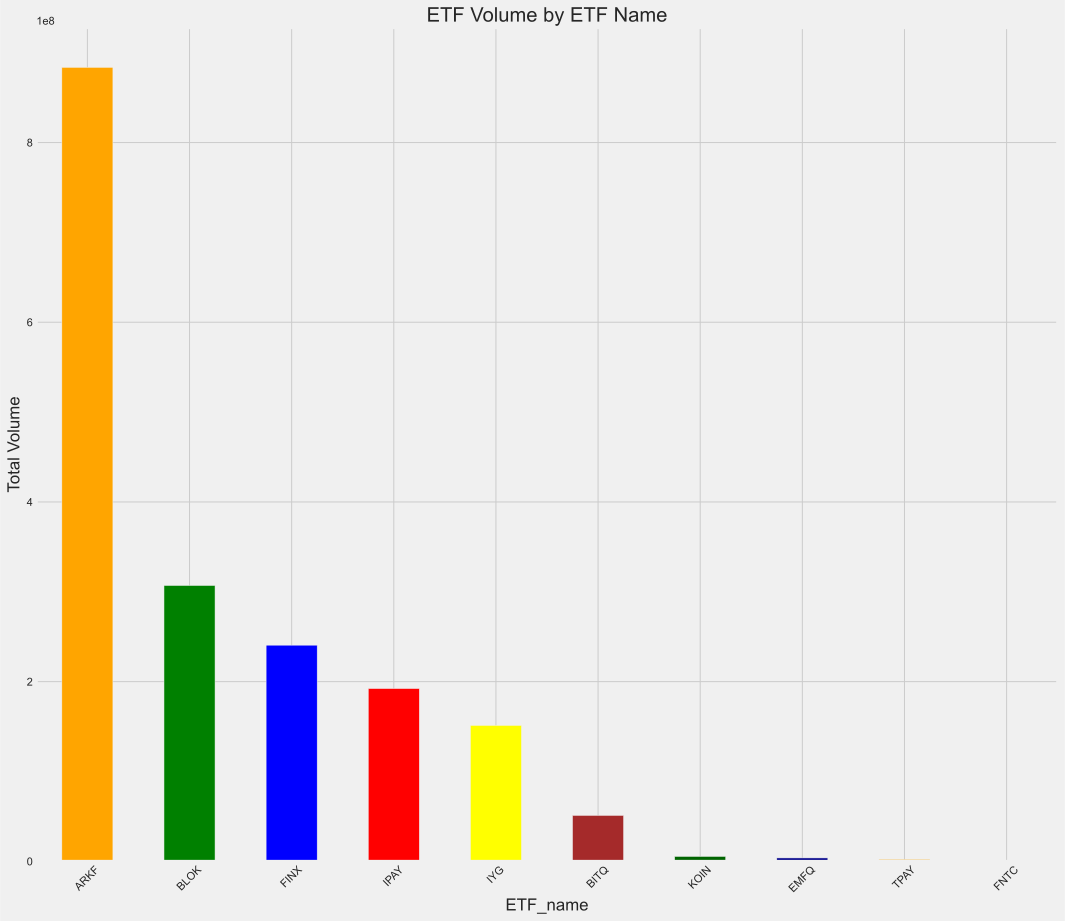

ETF_name
ARKF    883711400
BLOK    307012100
FINX    240608700
IPAY    192341300
IYG     151233100
BITQ     51067800
KOIN      5528700
EMFQ      3815000
TPAY      2087906
FNTC       337200
Name: Volume, dtype: int64

In [22]:
# plot
COLORS = ('orange','green', 'blue', 'red', 'yellow', 'brown', 'darkgreen', 'darkblue')


# Grouping by ETF_name and summing the Volume
volume_sum_by_etf = etf.groupby("ETF_name")["Volume"].sum()

# Sort the volume_sum_by_etf Series in descending order
volume_sum_by_etf = volume_sum_by_etf.sort_values(ascending=False)

# Plotting the bar plot
ax = volume_sum_by_etf.plot(kind='bar', color=COLORS, legend=False, grid=True)
ax.set_ylabel('Total Volume')
ax.set_title('ETF Volume by ETF Name')
plt.xticks(rotation=45)
    

plt.tight_layout()
plt.show()
volume_sum_by_etf


10 top differences between open and close volume - in date

line graph for mean between 4 datas for each ETF